## Рекуррентные сети

Для рекуррентных сетей используем датасет с именами и будем определять из какого языка произошло данное имя. Для этого построим рекуррентную сеть, которая с именами на уровне символов. Для начала скачаем файлы и конвертируем их к удобному формату (можно не особо вникать в этот код).

In [ ]:
# На Windows придется скачать архив по ссылке (~3Mb) и распаковать самостоятельно
#! wget -nc https://download.pytorch.org/tutorial/data.zip
#! unzip -n ./data.zip

In [2]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

['data/names/German.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Arabic.txt', 'data/names/Vietnamese.txt', 'data/names/Czech.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Polish.txt', 'data/names/Greek.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Japanese.txt']
Slusarski


Определим несколько удобных функций для конвертации букв и слов в тензоры.

**Задание 1 (1 балл)**: напишите последнюю функцию для конвертации слова в тензор.

In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensors = []
    for letter in line:
        tensors.append(letterToTensor(letter))
    return torch.cat(tensors, 0).view(len(line), 1, n_letters)

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**Задание 2 (3 балла):** Реализуйте однослойную рекуррентную сеть.

In [9]:
import torch.nn as nn
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()

        self.hidden_size = hidden_size
        self.features = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.ReLU()
        )

    def forward(self, input, hidden):
        stacked_input = torch.cat((input, hidden), dim=1)
        return self.features(stacked_input)

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnncell = RNNCell(n_letters, n_hidden)

Предсказание будем осуществлять при помощи линейного класссификатора поверх скрытых состояний сети.

In [10]:
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))

Проверим, что все корректно работает: выходы классификаторы должны быть лог-вероятностями.

In [11]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input, hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.9076, -2.9713, -2.9395, -2.9016, -2.8279, -2.9554, -2.7894, -2.9216,
         -2.9224, -2.8711, -2.8050, -2.8642, -2.8713, -2.8453, -2.9152, -2.8422,
         -2.9457, -2.9557]], grad_fn=<LogSoftmaxBackward0>)
tensor(1.0000, grad_fn=<SumBackward0>)


In [18]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input[0], hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.9615, -2.9595, -2.8341, -2.9626, -2.9180, -2.8194, -2.9054, -2.9577,
         -2.8187, -2.8408, -2.8871, -2.9489, -2.9271, -2.8794, -2.8503, -2.8368,
         -2.8859, -2.8569]], grad_fn=<LogSoftmaxBackward0>)
tensor(1.0000, grad_fn=<SumBackward0>)


Для простоты в этот раз будем оптимизировать не по мини-батчам, а по отдельным примерам. Ниже несколько полезных функций для этого.

In [19]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Murchadh
category = Russian / line = Vaiserman
category = Czech / line = Finferovy
category = Russian / line = Nurmuhametov
category = English / line = Stenhouse
category = Polish / line = Kowalczyk
category = Czech / line = Bleskan
category = Greek / line = Demas
category = Russian / line = Bakharev
category = Polish / line = Kosmatka


**Задание 3 (1 балл):** Реализуйте вычисление ответа в функции train. Если все сделано правильно, то точность на обучающей выборке должна быть не менее 70%.

100%|██████████| 50000/50000 [01:53<00:00, 441.17it/s]


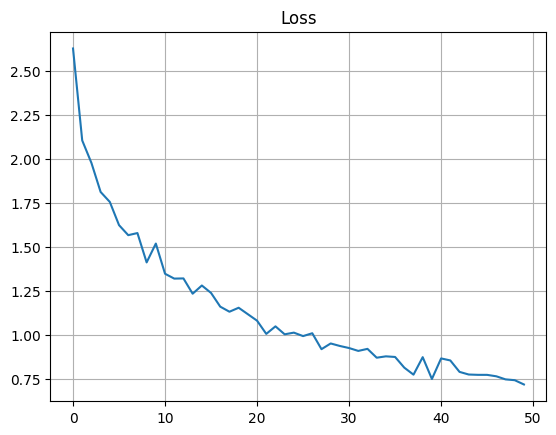

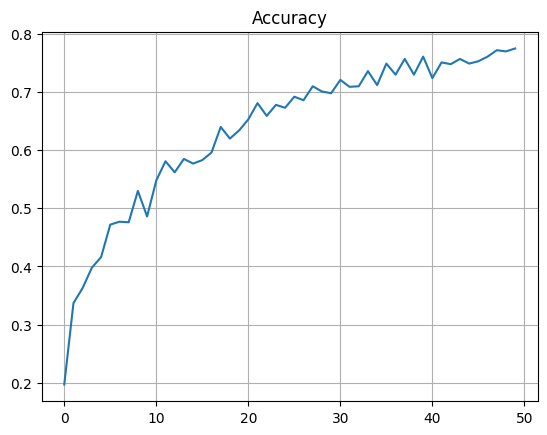

In [24]:
from tqdm import trange
import torch.nn.functional as F
def train(category, category_tensor, line_tensor, optimizer):
    hidden = rnncell.initHidden()

    rnncell.zero_grad()
    classifier.zero_grad()

    for letter_tensor in line_tensor:
        hidden = rnncell(letter_tensor, hidden)

    output = classifier(hidden)
    # output = output.squeeze(0)
    loss = F.nll_loss(output, category_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(output, 1)
    acc = (predicted == category_tensor).item()

    return loss.item(), acc

n_iters = 50000
plot_every = 1000

current_loss = 0
all_losses = []
current_acc = 0
all_accs = []

n_hidden = 128

rnncell = RNNCell(n_letters, n_hidden)
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))
params = list(rnncell.parameters()) + list(classifier.parameters())
opt = torch.optim.RMSprop(params, lr=0.001)
for iter in trange(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    loss, acc = train(category, category_tensor, line_tensor, opt)
    current_loss += loss
    current_acc += acc

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accs.append(current_acc / plot_every)
        current_acc = 0
import matplotlib.pyplot as plt
plt.figure()
plt.title("Loss")
plt.plot(all_losses)
plt.grid()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(all_accs)
plt.grid()
plt.show()

## Затухающие и взрывающиеся градиенты

Эксперименты будем проводить опять на датасете MNIST, но будем работать с полносвязными сетями. В этом разделе мы не будем пытаться подобрать более удачную архитектуру, нам интересно только посмотреть на особенности обучения глубоких сетей.

In [25]:
from mnist import load_mnist

(X_train, y_train), (X_val, y_val) = load_mnist(flatten=True)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [26]:
def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)

        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)

        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)

    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

Для экспериментов нам понадобится сеть, в которой можно легко менять количество слоев. Также эта сеть должна сохранять градиенты на всех слоях, чтобы потом мы могли посмотреть на их величины.

In [27]:
class DeepDenseNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation

        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]

        for i in range(n_layers):
            self.layers.append(self.activation)
            linear = nn.Linear(hidden_size, hidden_size)
            self.layers.append(linear)
            self.weights.append(linear.weight)

        self.seq = nn.Sequential(*self.layers)

        for l in self.weights:
            l.retain_grad()

    def forward(self, x):
        out = self.seq(x)
        return F.log_softmax(out, dim=-1)

Модифицируем наши функции обучения, чтобы они также рисовали графики изменения градиентов.

In [45]:
import scipy.sparse.linalg
import numpy as np
from IPython.display import clear_output
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def train_epoch_grad(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    grads = [[] for l in model.weights]
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)

        pred = torch.max(output, 1)[1].cpu().numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)

        for g, l in zip(grads, model.weights):
            g.append(np.linalg.norm(l.grad.cpu().numpy()))
    return loss_log, acc_log, grads


def train_grad(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    grads_log = None

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc, grads = train_epoch_grad(model, opt, batchsize=batchsize)
        if grads_log is None:
            grads_log = grads
        else:
            for a, b in zip(grads_log, grads):
                a.extend(b)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        # display all metrics
        clear_output()
        plot_history(train_log, val_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')

        plt.figure()
        all_vals = []
        for i, g in enumerate(grads_log):
            w = np.ones(100)
            w /= w.sum()
            vals = np.convolve(w, g, mode='valid')
            plt.semilogy(vals, label=str(i+1), color=plt.cm.coolwarm((i / len(grads_log))))
            all_vals.extend(vals)
        plt.legend(loc='best')
        plt.grid()
        plt.show()

**Задание 4 (1 балл):**
* Обучите сети глубины 10 и больше с сигмоидой в качестве активации. Исследуйте, как глубина влияет на качество обучения и поведение градиентов на далеких от выхода слоях.

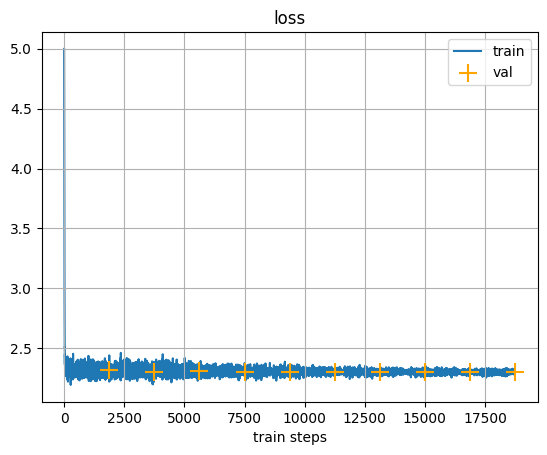

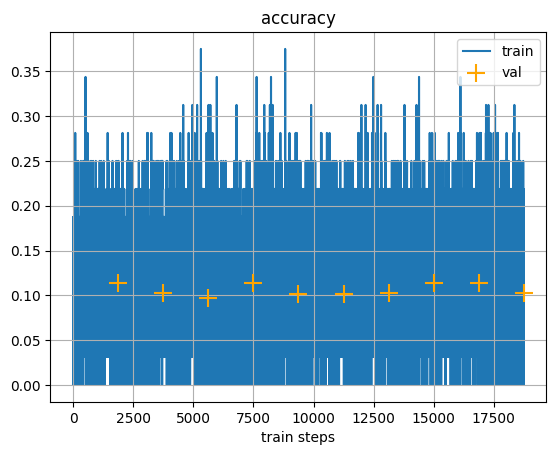

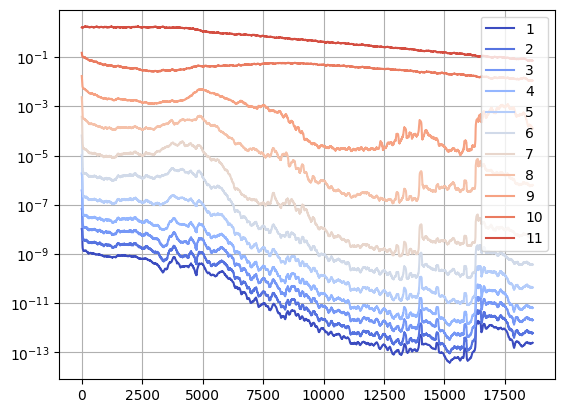

In [47]:
model = DeepDenseNet(n_layers=10, hidden_size=128, activation=torch.nn.Sigmoid())

train_grad(model, torch.optim.Adam(model.parameters()), n_epochs=10)

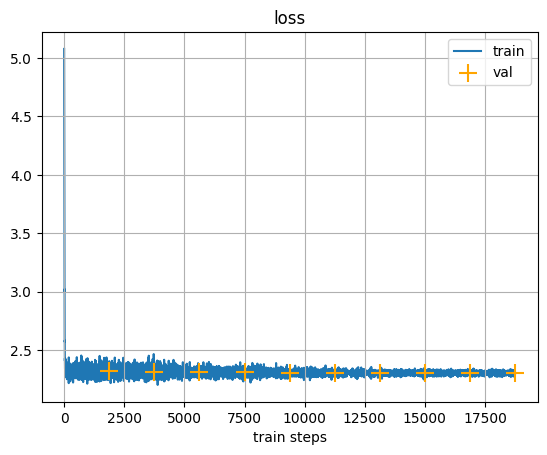

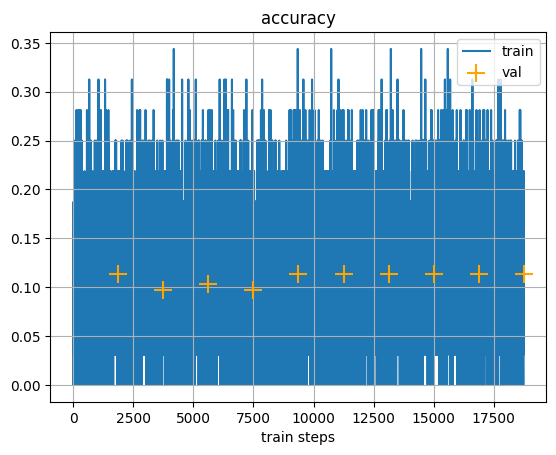

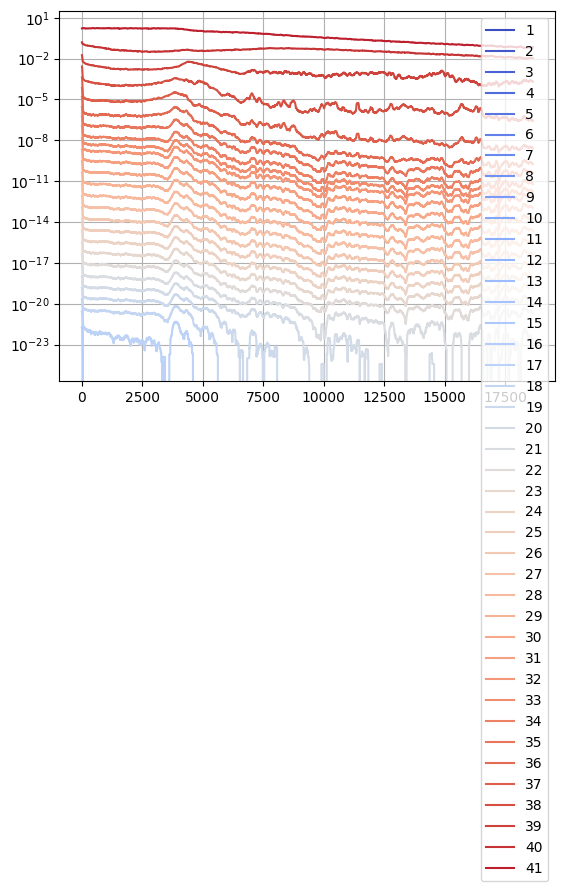

In [49]:
model = DeepDenseNet(n_layers=40, hidden_size=128, activation=torch.nn.Sigmoid())

train_grad(model, torch.optim.Adam(model.parameters()), n_epochs=10)

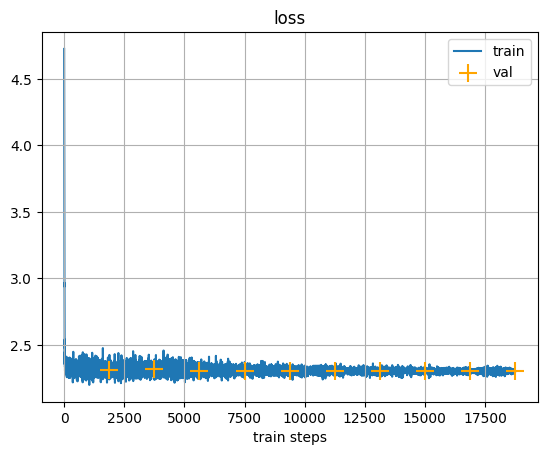

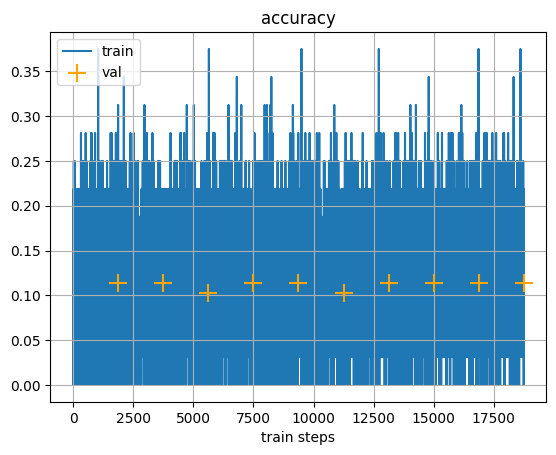

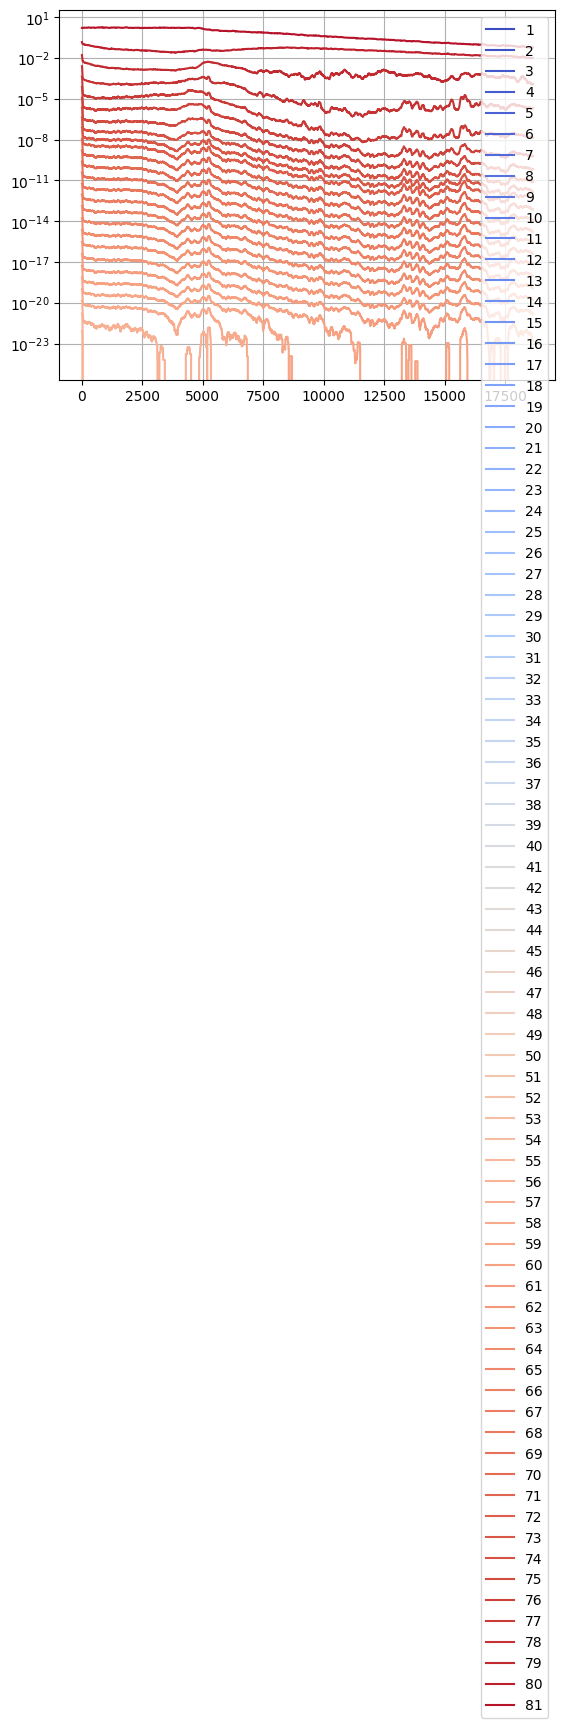

In [50]:
model = DeepDenseNet(n_layers=80, hidden_size=128, activation=torch.nn.Sigmoid())

train_grad(model, torch.optim.Adam(model.parameters()), n_epochs=10)

* Теперь замените активацию на ReLU и посмотрите, что получится.

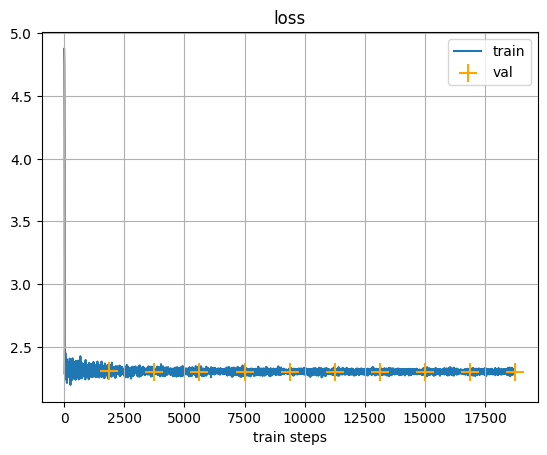

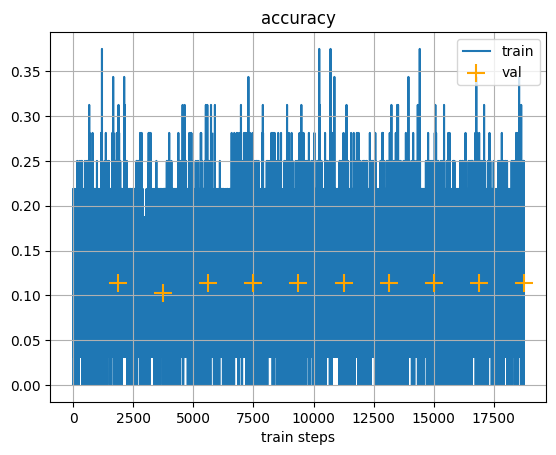

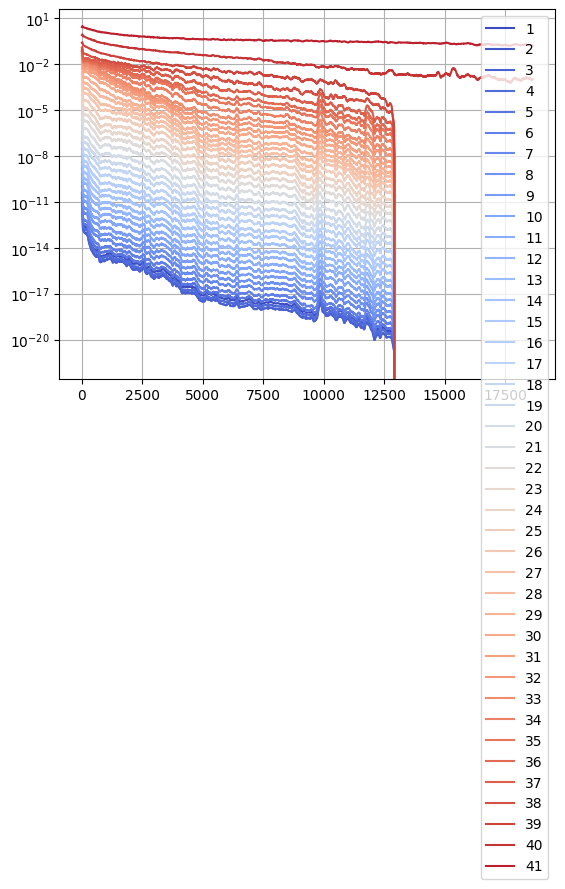

In [51]:
model = DeepDenseNet(n_layers=40, hidden_size=128, activation=torch.nn.ReLU())
train_grad(model, torch.optim.Adam(model.parameters()), 10)

Теперь попробуем добавить в сеть skip-connections (по примеру ResNet) вместо замены сигмоиды на relu и посмотрим, что получится. Запихнуть все слои в nn.Sequential и просто их применить теперь не получится - вместо этого мы их применим вручную. Но положить их в отдельный модуль nn.Sequential все равно нужно, иначе torch не сможет их найти и оптимизировать.

**Задание 5 (4 балла):** допишите недостающую часть кода ниже.

In [65]:
class DeepDenseResNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation

        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]

        for i in range(1, n_layers - 1):
            l = nn.Linear(hidden_size, hidden_size)
            self.layers.append(l)
            self.weights.append(l.weight)

        l = nn.Linear(hidden_size, 10)
        self.layers.append(l)
        self.weights.append(l.weight)

        self.seq = nn.Sequential(*self.layers)

        for l in self.weights:
            l.retain_grad()

    def forward(self, x):
        out = self.layers[0](x)
        out = self.activation(out)

        for i in range(1, len(self.layers) - 1):
            residual = out
            out = self.layers[i](out)
            out = self.activation(out)
            out = out + residual  # Skip connection
        out = self.layers[-1](out)


        return F.log_softmax(out, dim=-1)

Убедимся, что такая сеть отлично учится даже на большом числе слоев.

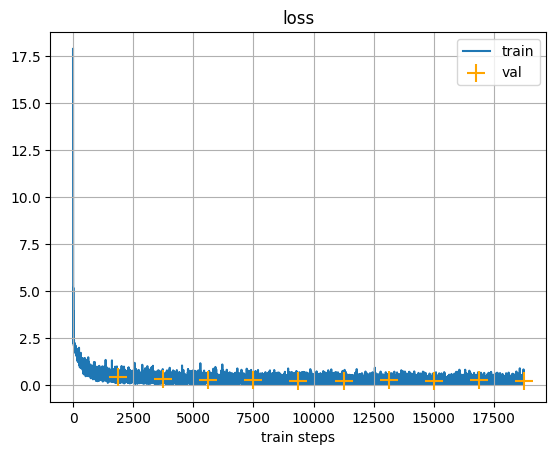

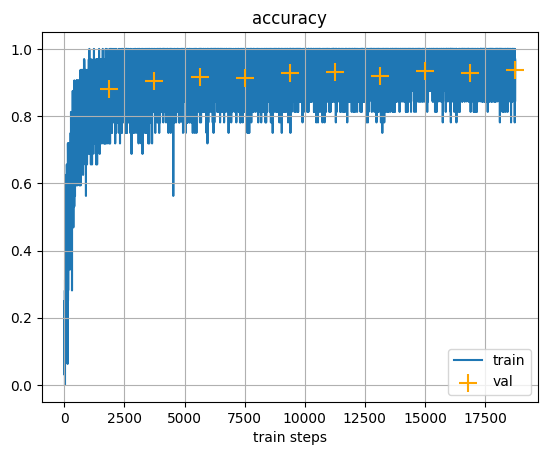

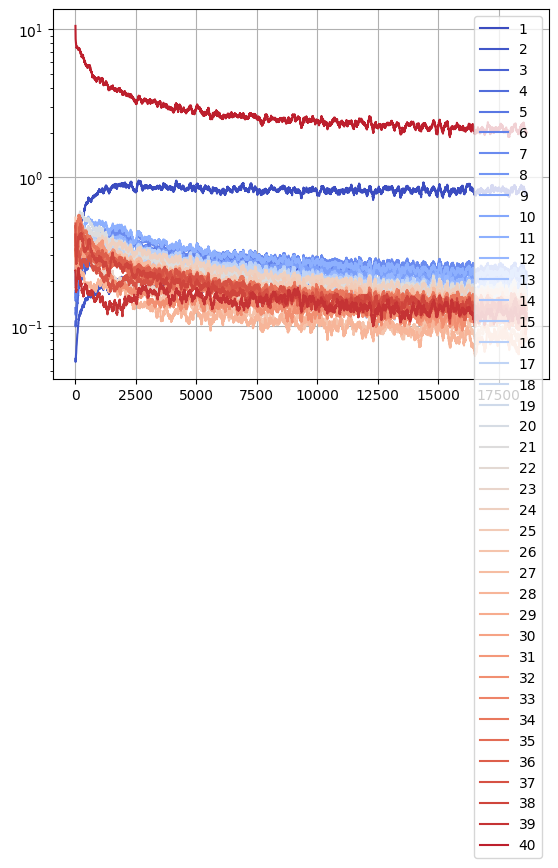

In [67]:
model = DeepDenseResNet(n_layers=40, hidden_size=10, activation=torch.nn.Sigmoid())
# там было 20, я поменял на 40, т.к. у меня было такое
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_grad(model, opt, 10)